In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from sklearn.linear_model import LinearRegression
import scipy.stats

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
dim_x = 3
dim_theta = 2

# Параметры распределения
mu_x = torch.tensor([1.0, -0.5, 2.0])
mu_theta = torch.tensor([0.8, -1.2])
mu_joint = torch.cat([mu_x, mu_theta])

Sigma_xx = torch.tensor([
    [2.0, 0.5, -0.3],
    [0.5, 1.5, 0.2],
    [-0.3, 0.2, 2.5]
])

Sigma_tt = torch.tensor([
    [1.5, 0.7],
    [0.7, 2.0]
])

Sigma_xtheta = torch.tensor([
    [0.9, -0.4],
    [0.6, 0.8],
    [-0.2, 0.5]
])

Sigma_thetax = Sigma_xtheta.T

top_row = torch.cat([Sigma_xx, Sigma_xtheta], dim=1)
bottom_row = torch.cat([Sigma_thetax, Sigma_tt], dim=1)
cov_matrix_joint = torch.cat([top_row, bottom_row], dim=0)
cov_matrix_joint += torch.eye(cov_matrix_joint.shape[0]) * 1e-3

multivariate_normal = MultivariateNormal(mu_joint.to(device), cov_matrix_joint.to(device))

### Аналитические решения

In [3]:
def analytical_theta_given_x(x):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)

    x = x.to(device)
    Sigma_xx_inv = torch.linalg.inv(Sigma_xx.to(device))
    diff = x - mu_x.to(device)
    conditional_mean = mu_theta.to(device) + diff @ (Sigma_xx_inv @ Sigma_thetax.to(device).T)
    return conditional_mean

def analytical_variance_given_x(x):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)

    x = x.to(device)
    Sigma_xx_inv = torch.linalg.inv(Sigma_xx.to(device))
    conditional_cov = Sigma_tt.to(device) - Sigma_thetax.to(device) @ Sigma_xx_inv @ Sigma_xtheta.to(device)
    conditional_var = torch.diag(conditional_cov)
    batch_size = x.shape[0]
    return conditional_var.unsqueeze(0).repeat(batch_size, 1)

def analytical_quantile_given_x(x, rho):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)

    x = x.to(device)
    mean = analytical_theta_given_x(x)
    var = analytical_variance_given_x(x)
    std = torch.sqrt(var)
    z_score = torch.tensor(scipy.stats.norm.ppf(rho), device=device)

    return mean + std * z_score

### Лосы

In [4]:
def L_se_loss(pred_theta, true_theta):
    return torch.mean(torch.sum((pred_theta - true_theta)**2, dim=1))

def L_var_loss(pred_variance, true_theta, conditional_mean):
    squared_error = (true_theta - conditional_mean)**2
    return torch.mean((squared_error - pred_variance)**2)

def L_rho_loss(pred_quantile, true_theta, rho):
    indicator = (pred_quantile > true_theta).float()
    loss = (pred_quantile - true_theta) * (indicator - rho)
    return torch.mean(torch.sum(loss, dim=1))

### Нейронки

In [5]:
class BasePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[16]):
        super().__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU()
            ])
            prev_dim = hidden_dim

        self.shared_net = nn.Sequential(*layers)
        self.hidden_dim = prev_dim

class MeanPredictor(BasePredictor):
    def __init__(self, input_dim, output_dim):
        super().__init__(input_dim)
        self.head = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, x):
        features = self.shared_net(x)
        return self.head(features)

class VariancePredictor(BasePredictor):
    def __init__(self, input_dim, output_dim):
        super().__init__(input_dim)
        self.head = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, x):
        features = self.shared_net(x)
        return torch.nn.functional.softplus(self.head(features))

class QuantilePredictor(BasePredictor):
    def __init__(self, input_dim, output_dim):
        super().__init__(input_dim)
        self.head = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, x):
        features = self.shared_net(x)
        return self.head(features)

### Генерация данных

In [6]:
num_samples = 200000
joint_samples = multivariate_normal.sample((num_samples,))
x_data = joint_samples[:, :dim_x]
theta_data = joint_samples[:, dim_x:]

train_ratio = 0.8
split_idx = int(num_samples * train_ratio)

x_train = x_data[:split_idx]
theta_train = theta_data[:split_idx]
x_test = x_data[split_idx:]
theta_test = theta_data[split_idx:]

### Обучение

In [7]:
def l1_penalty(model, l1_lambda):
    l1_norm = 0.0
    for name, param in model.named_parameters():
        if 'weight' in name:
            l1_norm += torch.norm(param, 1)
    return l1_lambda * l1_norm

In [8]:
def train_models(x_train, theta_train, x_test, theta_test, num_epochs=30, l1_lambda=1e-3):
    mean_model = MeanPredictor(dim_x, dim_theta).to(device)
    var_model = VariancePredictor(dim_x, dim_theta).to(device)
    quantile_model = QuantilePredictor(dim_x, dim_theta).to(device)

    mean_optimizer = optim.Adam(mean_model.parameters(), lr=0.001)
    var_optimizer = optim.Adam(var_model.parameters(), lr=0.001)
    quantile_optimizer = optim.Adam(quantile_model.parameters(), lr=0.001)

    train_dataset = torch.utils.data.TensorDataset(x_train, theta_train)
    test_dataset = torch.utils.data.TensorDataset(x_test, theta_test)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

    train_mean_losses, train_var_losses, train_quantile_losses = [], [], []
    test_mean_losses, test_var_losses, test_quantile_losses = [], [], []

    rho = 0.5

    for epoch in range(num_epochs):
        mean_model.train()
        var_model.train()
        quantile_model.train()

        train_mean_epoch_loss, train_var_epoch_loss, train_quantile_epoch_loss = 0, 0, 0

        for batch_x, batch_theta in train_loader:
            batch_x, batch_theta = batch_x.to(device), batch_theta.to(device)

            mean_optimizer.zero_grad()
            pred_mean = mean_model(batch_x)
            mean_loss = L_se_loss(pred_mean, batch_theta)

            mean_loss_with_l1 = mean_loss + l1_penalty(mean_model, l1_lambda)

            mean_loss_with_l1.backward()
            mean_optimizer.step()
            train_mean_epoch_loss += mean_loss.item()

            var_optimizer.zero_grad()
            pred_var = var_model(batch_x)
            conditional_mean = analytical_theta_given_x(batch_x).detach()
            var_loss = L_var_loss(pred_var, batch_theta, conditional_mean)

            var_loss_with_l1 = var_loss + l1_penalty(var_model, l1_lambda)

            var_loss_with_l1.backward()
            var_optimizer.step()
            train_var_epoch_loss += var_loss.item()

            quantile_optimizer.zero_grad()
            pred_quantile = quantile_model(batch_x)
            quantile_loss = L_rho_loss(pred_quantile, batch_theta, rho)

            quantile_loss_with_l1 = quantile_loss + l1_penalty(quantile_model, l1_lambda)

            quantile_loss_with_l1.backward()
            quantile_optimizer.step()
            train_quantile_epoch_loss += quantile_loss.item()

        mean_model.eval()
        var_model.eval()
        quantile_model.eval()

        test_mean_epoch_loss, test_var_epoch_loss, test_quantile_epoch_loss = 0, 0, 0

        with torch.no_grad():
            for batch_x, batch_theta in test_loader:
                batch_x, batch_theta = batch_x.to(device), batch_theta.to(device)

                pred_mean = mean_model(batch_x)
                mean_loss = L_se_loss(pred_mean, batch_theta)
                test_mean_epoch_loss += mean_loss.item()

                pred_var = var_model(batch_x)
                conditional_mean = analytical_theta_given_x(batch_x)
                var_loss = L_var_loss(pred_var, batch_theta, conditional_mean)
                test_var_epoch_loss += var_loss.item()

                pred_quantile = quantile_model(batch_x)
                quantile_loss = L_rho_loss(pred_quantile, batch_theta, rho)
                test_quantile_epoch_loss += quantile_loss.item()

        train_mean_losses.append(train_mean_epoch_loss / len(train_loader))
        train_var_losses.append(train_var_epoch_loss / len(train_loader))
        train_quantile_losses.append(train_quantile_epoch_loss / len(train_loader))

        test_mean_losses.append(test_mean_epoch_loss / len(test_loader))
        test_var_losses.append(test_var_epoch_loss / len(test_loader))
        test_quantile_losses.append(test_quantile_epoch_loss / len(test_loader))

    return (mean_model, var_model, quantile_model,
            train_mean_losses, train_var_losses, train_quantile_losses,
            test_mean_losses, test_var_losses, test_quantile_losses)
(mean_model, var_model, quantile_model,
train_mean_losses, train_var_losses, train_quantile_losses,
test_mean_losses, test_var_losses, test_quantile_losses) = train_models(
x_train, theta_train, x_test, theta_test
)

### Визуализация

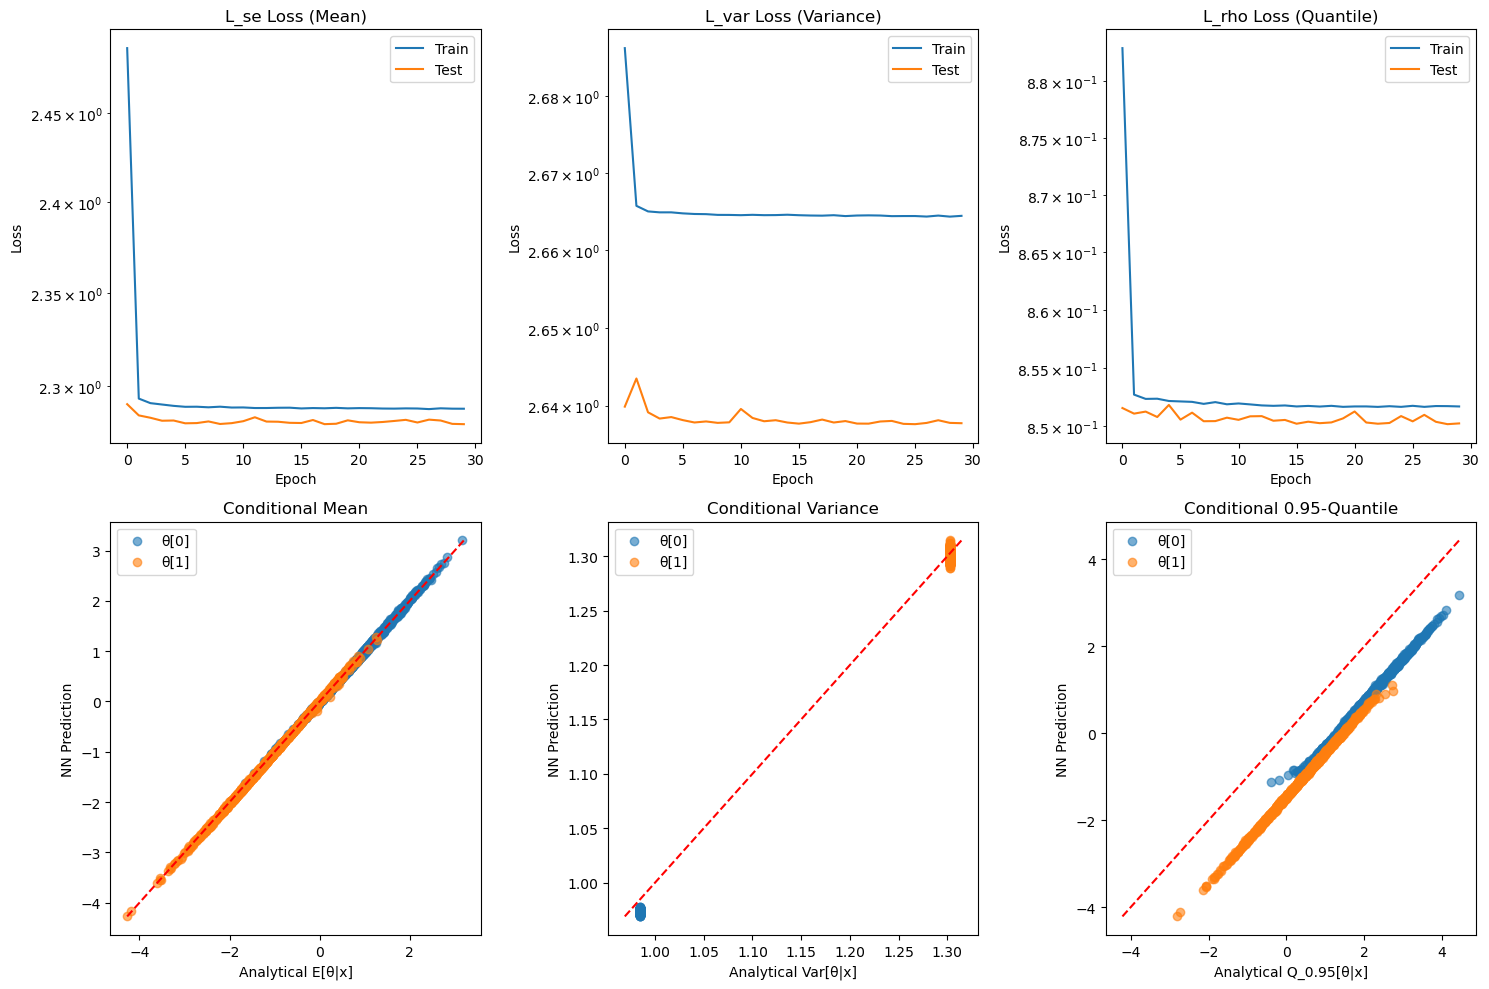


Количественное сравнение:
Средняя абсолютная ошибка предсказания среднего: 0.018541
Средняя абсолютная ошибка предсказания дисперсии: 0.007299
Средняя абсолютная ошибка предсказания квантиля: 1.362740


In [9]:
viz_indices = torch.randperm(len(x_test))[:1000]
x_viz = x_test[viz_indices]


mean_model.eval()
var_model.eval()
quantile_model.eval()

with torch.no_grad():
    pred_mean = mean_model(x_viz)
    pred_var = var_model(x_viz)
    pred_quantile = quantile_model(x_viz)

    analytical_mean = analytical_theta_given_x(x_viz)
    analytical_var = analytical_variance_given_x(x_viz)
    analytical_quantile = analytical_quantile_given_x(x_viz, 0.9)

x_viz = x_viz.cpu()
pred_mean, pred_var, pred_quantile = pred_mean.cpu(), pred_var.cpu(), pred_quantile.cpu()
analytical_mean, analytical_var, analytical_quantile = analytical_mean.cpu(), analytical_var.cpu(), analytical_quantile.cpu()

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(train_mean_losses, label='Train')
plt.plot(test_mean_losses, label='Test')
plt.title('L_se Loss (Mean)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(train_var_losses, label='Train')
plt.plot(test_var_losses, label='Test')
plt.title('L_var Loss (Variance)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(train_quantile_losses, label='Train')
plt.plot(test_quantile_losses, label='Test')
plt.title('L_rho Loss (Quantile)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()


plt.subplot(2, 3, 4)
for i in range(dim_theta):
    plt.scatter(analytical_mean[:, i], pred_mean[:, i], alpha=0.6, label=f'θ[{i}]')
min_val = min(analytical_mean.min(), pred_mean.min())
max_val = max(analytical_mean.max(), pred_mean.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel('Analytical E[θ|x]')
plt.ylabel('NN Prediction')
plt.title('Conditional Mean')
plt.legend()


plt.subplot(2, 3, 5)
for i in range(dim_theta):
    plt.scatter(analytical_var[:, i], pred_var[:, i], alpha=0.6, label=f'θ[{i}]')
min_val = min(analytical_var.min(), pred_var.min())
max_val = max(analytical_var.max(), pred_var.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel('Analytical Var[θ|x]')
plt.ylabel('NN Prediction')
plt.title('Conditional Variance')
plt.legend()


plt.subplot(2, 3, 6)
for i in range(dim_theta):
    plt.scatter(analytical_quantile[:, i], pred_quantile[:, i], alpha=0.6, label=f'θ[{i}]')
min_val = min(analytical_quantile.min(), pred_quantile.min())
max_val = max(analytical_quantile.max(), pred_quantile.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel('Analytical Q_0.95[θ|x]')
plt.ylabel('NN Prediction')
plt.title('Conditional 0.95-Quantile')
plt.legend()

plt.tight_layout()
plt.show()


print("\n" + "="*50)
print("Количественное сравнение:")
print("="*50)

mean_error = torch.mean(torch.abs(pred_mean - analytical_mean)).item()
var_error = torch.mean(torch.abs(pred_var - analytical_var)).item()
quantile_error = torch.mean(torch.abs(pred_quantile - analytical_quantile)).item()

print(f"Средняя абсолютная ошибка предсказания среднего: {mean_error:.6f}")
print(f"Средняя абсолютная ошибка предсказания дисперсии: {var_error:.6f}")
print(f"Средняя абсолютная ошибка предсказания квантиля: {quantile_error:.6f}")

Обучение на разных размерах выборки...
Размер выборки: 32
  Дисперсия pred_mean: theta_0=0.052848, theta_1=0.112814
  Дисперсия pred_var: theta_0=0.010550, theta_1=0.035293
  Дисперсия pred_quantile: theta_0=0.131130, theta_1=0.129789
Размер выборки: 64
  Дисперсия pred_mean: theta_0=0.084394, theta_1=0.027023
  Дисперсия pred_var: theta_0=0.015067, theta_1=0.028947
  Дисперсия pred_quantile: theta_0=0.053819, theta_1=0.064087
Размер выборки: 128
  Дисперсия pred_mean: theta_0=0.079858, theta_1=0.045526
  Дисперсия pred_var: theta_0=0.032271, theta_1=0.046324
  Дисперсия pred_quantile: theta_0=0.024988, theta_1=0.037128
Размер выборки: 256
  Дисперсия pred_mean: theta_0=0.193698, theta_1=0.122599
  Дисперсия pred_var: theta_0=0.010521, theta_1=0.022757
  Дисперсия pred_quantile: theta_0=0.133929, theta_1=0.064764
Размер выборки: 512
  Дисперсия pred_mean: theta_0=0.119265, theta_1=0.046005
  Дисперсия pred_var: theta_0=0.021917, theta_1=0.090799
  Дисперсия pred_quantile: theta_0=0.198

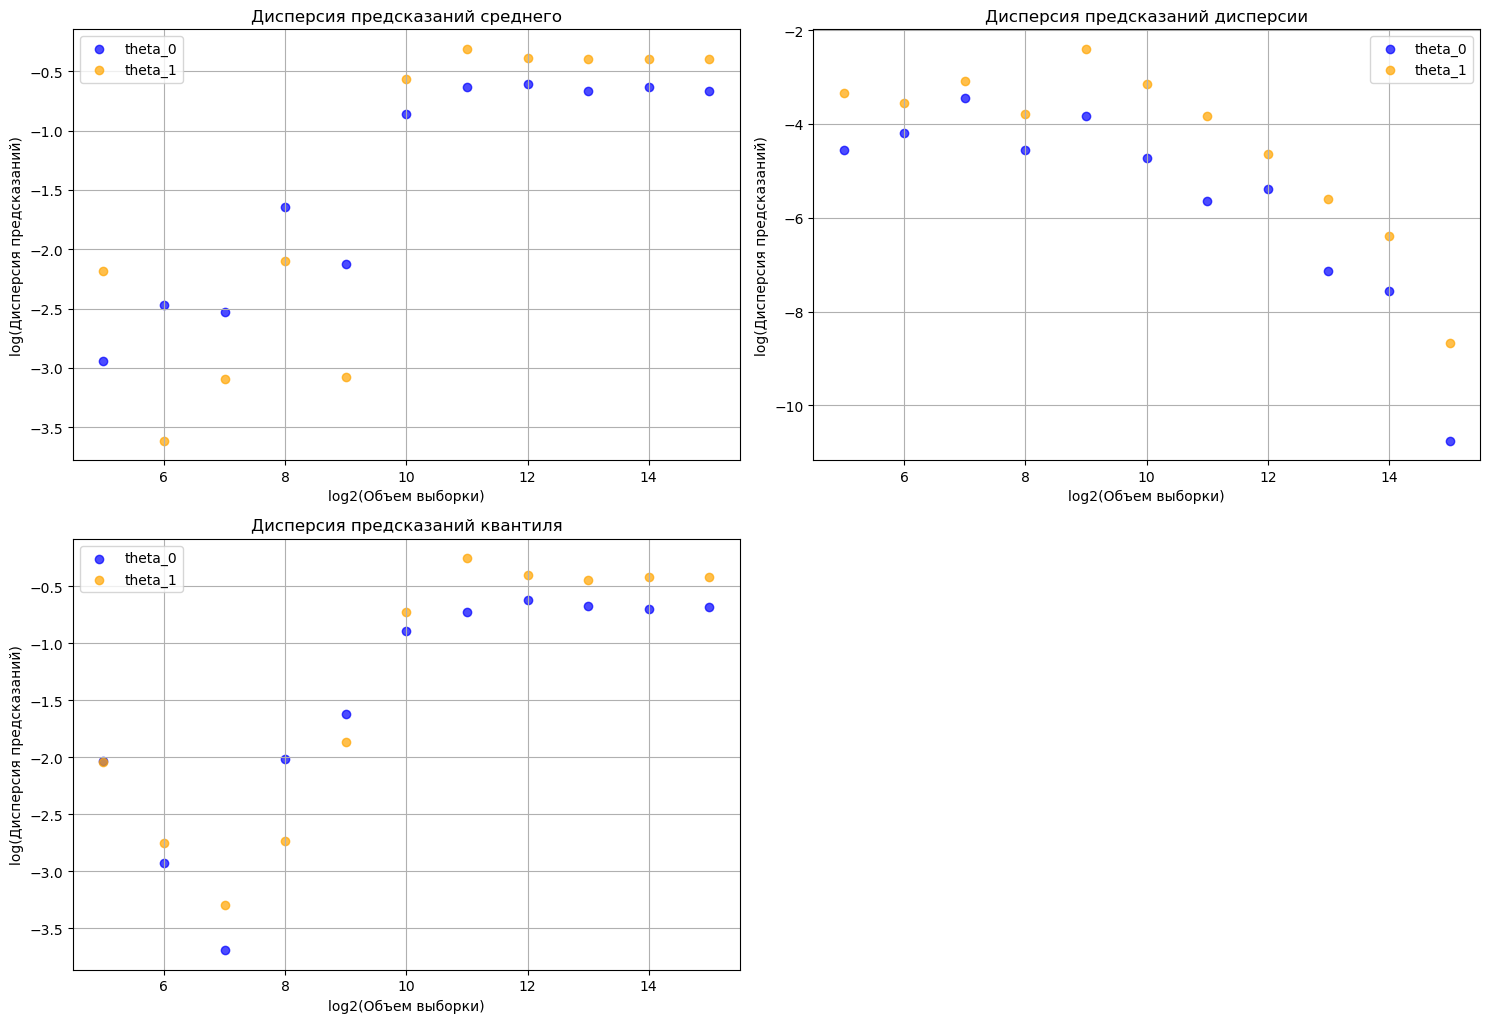

In [10]:
sample_sizes = [2**i for i in range(5, 16)]
log_sample_sizes = np.log2(sample_sizes)

mean_variances_0 = []
mean_variances_1 = []
var_variances_0 = []
var_variances_1 = []
quantile_variances_0 = []
quantile_variances_1 = []

print("Обучение на разных размерах выборки...")
for size in sample_sizes:
    indices = torch.randperm(len(x_train))[:size]
    x_subset = x_train[indices]
    theta_subset = theta_train[indices]

    (mean_model_temp, var_model_temp, quantile_model_temp,
     _, _, _,
     _, _, _) = train_models(x_subset, theta_subset, x_test, theta_test, num_epochs=30)

    mean_model_temp.eval()
    var_model_temp.eval()
    quantile_model_temp.eval()

    with torch.no_grad():
        pred_mean = mean_model_temp(x_test)
        pred_var = var_model_temp(x_test)
        pred_quantile = quantile_model_temp(x_test)

        mean_variance_0 = torch.var(pred_mean[:, 0]).item()
        mean_variance_1 = torch.var(pred_mean[:, 1]).item()
        var_variance_0 = torch.var(pred_var[:, 0]).item()
        var_variance_1 = torch.var(pred_var[:, 1]).item()
        quantile_variance_0 = torch.var(pred_quantile[:, 0]).item()
        quantile_variance_1 = torch.var(pred_quantile[:, 1]).item()

        mean_variances_0.append(mean_variance_0)
        mean_variances_1.append(mean_variance_1)
        var_variances_0.append(var_variance_0)
        var_variances_1.append(var_variance_1)
        quantile_variances_0.append(quantile_variance_0)
        quantile_variances_1.append(quantile_variance_1)

    print(f"Размер выборки: {size}")
    print(f"  Дисперсия pred_mean: theta_0={mean_variance_0:.6f}, theta_1={mean_variance_1:.6f}")
    print(f"  Дисперсия pred_var: theta_0={var_variance_0:.6f}, theta_1={var_variance_1:.6f}")
    print(f"  Дисперсия pred_quantile: theta_0={quantile_variance_0:.6f}, theta_1={quantile_variance_1:.6f}")


log_mean_variances_0 = np.log(mean_variances_0)
log_mean_variances_1 = np.log(mean_variances_1)
log_var_variances_0 = np.log(var_variances_0)
log_var_variances_1 = np.log(var_variances_1)
log_quantile_variances_0 = np.log(quantile_variances_0)
log_quantile_variances_1 = np.log(quantile_variances_1)

plt.figure(figsize=(15, 15))

plt.subplot(3, 2, 1)
plt.scatter(log_sample_sizes, log_mean_variances_0, alpha=0.7, label='theta_0', color='blue')
plt.scatter(log_sample_sizes, log_mean_variances_1, alpha=0.7, label='theta_1', color='orange')
plt.xlabel('log2(Объем выборки)')
plt.ylabel('log(Дисперсия предсказаний)')
plt.title('Дисперсия предсказаний среднего')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 2)
plt.scatter(log_sample_sizes, log_var_variances_0, alpha=0.7, label='theta_0', color='blue')
plt.scatter(log_sample_sizes, log_var_variances_1, alpha=0.7, label='theta_1', color='orange')
plt.xlabel('log2(Объем выборки)')
plt.ylabel('log(Дисперсия предсказаний)')
plt.title('Дисперсия предсказаний дисперсии')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 3)
plt.scatter(log_sample_sizes, log_quantile_variances_0, alpha=0.7, label='theta_0', color='blue')
plt.scatter(log_sample_sizes, log_quantile_variances_1, alpha=0.7, label='theta_1', color='orange')
plt.xlabel('log2(Объем выборки)')
plt.ylabel('log(Дисперсия предсказаний)')
plt.title('Дисперсия предсказаний квантиля')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:


print("\n" + "="*50)
print(f"Сравнение весов моделей (A -> 0 ?)")
print("="*50)

(mean_model_small, var_model_small, quantile_model_small,
 _, _, _, _, _, _) = train_models(
     x_train[:32], theta_train[:32], x_test, theta_test,

 )

(mean_model_large, var_model_large, quantile_model_large,
 _, _, _, _, _, _) = train_models(
     x_train, theta_train, x_test, theta_test
 )

print("\n--- Модель Дисперсии (VariancePredictor) ---")

weights_small_A = var_model_small.shared_net[0].weight
weights_large_A = var_model_large.shared_net[0].weight

norm_small = torch.mean(torch.abs(weights_small_A)).item()
norm_large = torch.mean(torch.abs(weights_large_A)).item()

print(f"Средняя L1 норма весов (A) на N=32:     {norm_small:.6f}")
print(f"Средняя L1 норма весов (A) на N={len(x_train)}: {norm_large:.6f}")

if norm_large < norm_small / 2:
    print(">>> УСПЕХ: Веса 'схлопнулись' очень сильно (ближе к 0)")
else:
    print(">>> (Веса уменьшились, но не так сильно. Попробуйте увеличить l1_strength или num_epochs)")


print("\n--- Модель Среднего (MeanPredictor) ---")
weights_mean_small_A = mean_model_small.shared_net[0].weight
weights_mean_large_A = mean_model_large.shared_net[0].weight

norm_mean_small = torch.mean(torch.abs(weights_mean_small_A)).item()
norm_mean_large = torch.mean(torch.abs(weights_mean_large_A)).item()

print(f"Средняя L1 норма весов (A) на N=32:     {norm_mean_small:.6f}")
print(f"Средняя L1 норма весов (A) на N={len(x_train)}: {norm_mean_large:.6f}")


Сравнение весов моделей (A -> 0 ?)


KeyboardInterrupt: 

In [ ]:
print("\n" + "="*50)
print("Прямой осмотр весов (матрицы A)")
print("="*50)

var_weights_A = var_model_large.shared_net[0].weight

print(f"\n--- Модель Дисперсии (VariancePredictor) ---")
print(f"Веса A (shape {var_weights_A.shape}):")
print(var_weights_A)

mean_weights_A = mean_model_large.shared_net[0].weight

print(f"\n--- Модель Среднего (MeanPredictor) ---")
print(f"Веса A (shape {mean_weights_A.shape}):")
print(mean_weights_A)


Прямой осмотр весов (матрицы A)

--- Модель Дисперсии (VariancePredictor) ---
Веса A (shape torch.Size([16, 3])):
Parameter containing:
tensor([[-2.1532e-04, -1.5756e-04, -1.4539e-05],
        [-9.9012e-05,  1.0539e-04, -2.3386e-04],
        [ 1.3711e-04,  7.9652e-05, -9.5148e-05],
        [ 3.1954e-07, -4.6901e-05,  5.2711e-05],
        [ 4.4885e-03,  1.0192e-03, -7.7835e-03],
        [-7.2531e-06, -1.6924e-04,  5.4945e-05],
        [ 7.4835e-05,  2.9732e-05, -9.0821e-05],
        [-2.3177e-05,  1.2425e-04, -2.5066e-04],
        [ 1.6490e-04,  1.1765e-04, -1.4640e-05],
        [ 4.3699e-04, -1.2661e-04, -1.3936e-04],
        [ 2.3232e-04,  1.2569e-05, -4.0691e-06],
        [ 3.2534e-03, -1.7358e-03, -7.8428e-03],
        [-1.0760e-04, -2.5573e-04,  2.2627e-05],
        [ 3.7861e-05,  8.0464e-05,  1.4228e-04],
        [-2.3535e-05, -1.9275e-04,  8.5523e-05],
        [ 8.0606e-05, -1.0383e-04,  7.1288e-05]], device='cuda:0',
       requires_grad=True)

--- Модель Среднего (MeanPredicto

Запуск эксперимента по размерам выборки...


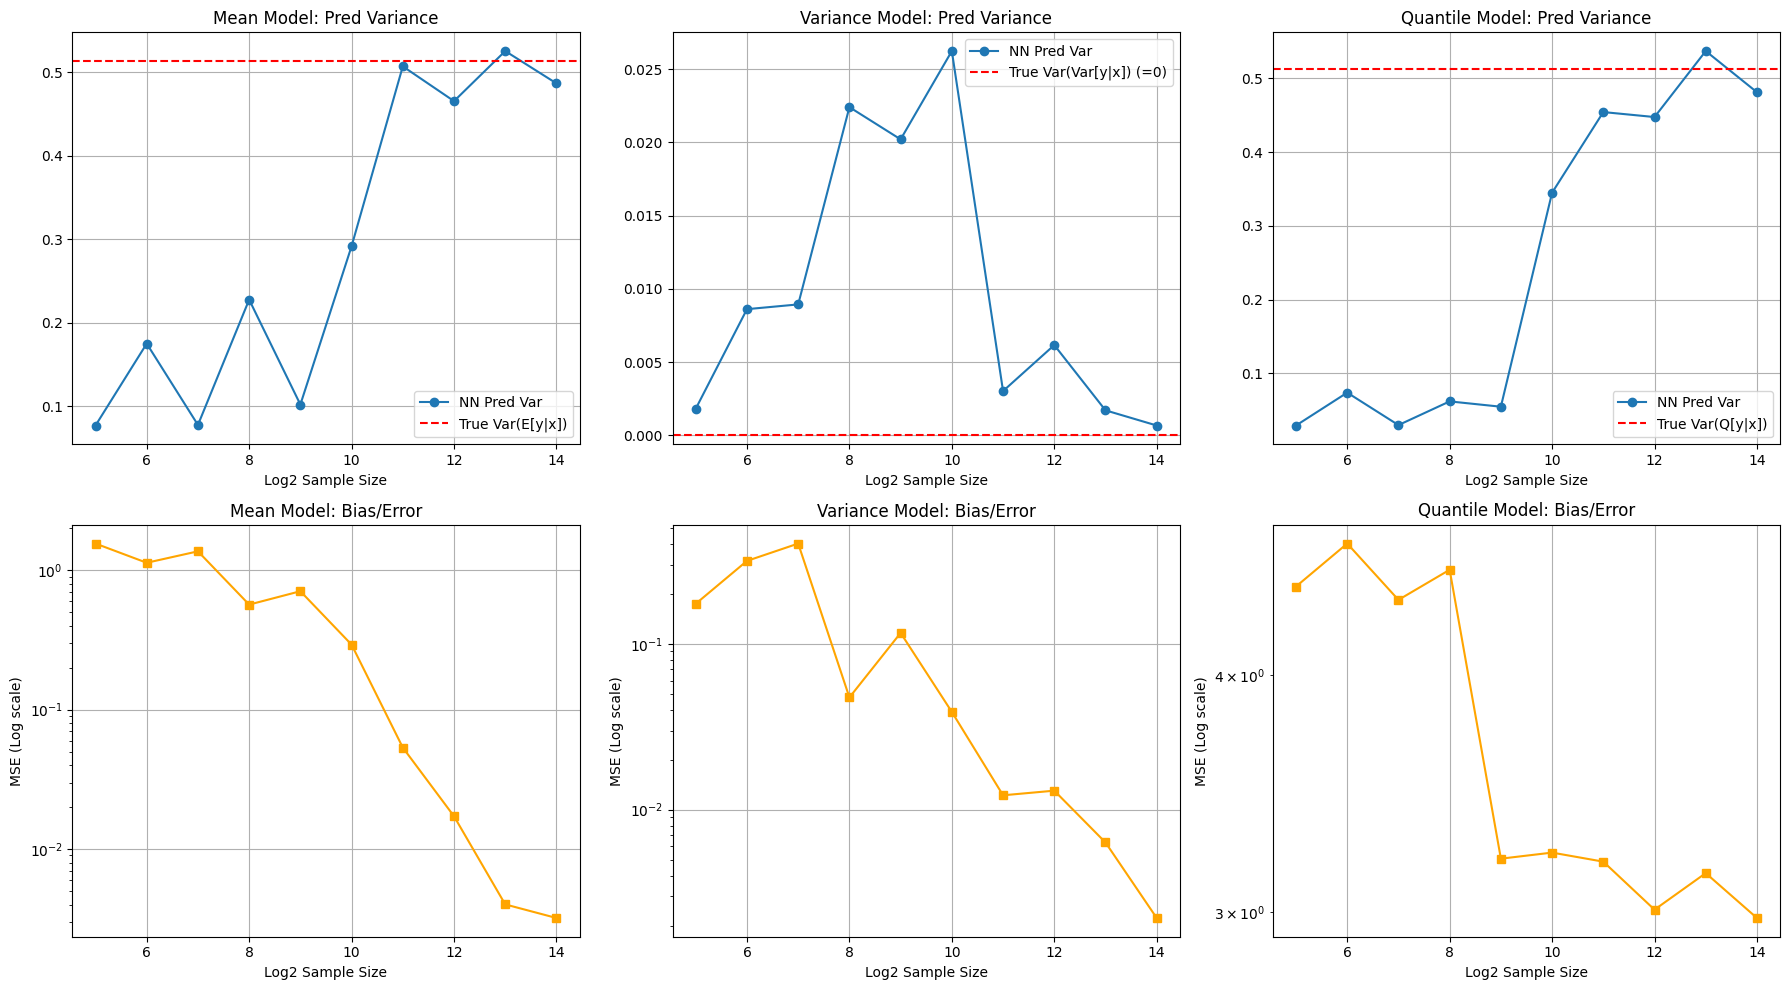

In [ ]:

analytical_mean_val = analytical_theta_given_x(x_test).cpu()
true_pred_mean_var = torch.var(analytical_mean_val, dim=0).numpy()

analytical_var_val = analytical_variance_given_x(x_test).cpu()
true_pred_var_var = torch.var(analytical_var_val, dim=0).numpy()

analytical_quantile_val = analytical_quantile_given_x(x_test, 0.95).cpu()
true_pred_quantile_var = torch.var(analytical_quantile_val, dim=0).numpy()


sample_sizes = [2**i for i in range(5, 15)]
log_sample_sizes = np.log2(sample_sizes)

history = {
    'mean_pred_var': [], 'var_pred_var': [], 'quant_pred_var': [], 
    'mean_mse': [],      'var_mse': [],      'quant_mse': []      
}

print("Запуск эксперимента по размерам выборки...")

for size in sample_sizes:
    indices = torch.randperm(len(x_train))[:size]
    x_sub = x_train[indices]
    t_sub = theta_train[indices]

    (m_model, v_model, q_model, _,_,_,_,_,_) = train_models(
        x_sub, t_sub, x_test, theta_test, num_epochs=20, l1_lambda=1e-4
    )

    with torch.no_grad():
        p_mean = m_model(x_test).cpu()
        p_var = v_model(x_test).cpu()
        p_quant = q_model(x_test).cpu()
        
    history['mean_pred_var'].append(torch.var(p_mean[:, 0]).item())
    history['var_pred_var'].append(torch.var(p_var[:, 0]).item())
    history['quant_pred_var'].append(torch.var(p_quant[:, 0]).item())

    mse_mean = torch.mean((p_mean - analytical_mean_val)**2).item()
    mse_var = torch.mean((p_var - analytical_var_val)**2).item()
    mse_quant = torch.mean((p_quant - analytical_quantile_val)**2).item()

    history['mean_mse'].append(mse_mean)
    history['var_mse'].append(mse_var)
    history['quant_mse'].append(mse_quant)

plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.plot(log_sample_sizes, history['mean_pred_var'], 'o-', label='NN Pred Var')
plt.axhline(y=true_pred_mean_var[0], color='r', linestyle='--', label='True Var(E[y|x])')
plt.title('Mean Model: Pred Variance')
plt.xlabel('Log2 Sample Size')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(log_sample_sizes, history['var_pred_var'], 'o-', label='NN Pred Var')
plt.axhline(y=true_pred_var_var[0], color='r', linestyle='--', label='True Var(Var[y|x]) (=0)')
plt.title('Variance Model: Pred Variance')
plt.xlabel('Log2 Sample Size')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(log_sample_sizes, history['quant_pred_var'], 'o-', label='NN Pred Var')
plt.axhline(y=true_pred_quantile_var[0], color='r', linestyle='--', label='True Var(Q[y|x])')
plt.title('Quantile Model: Pred Variance')
plt.xlabel('Log2 Sample Size')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(log_sample_sizes, history['mean_mse'], 's-', color='orange', label='MSE vs True Mean')
plt.title('Mean Model: Bias/Error')
plt.ylabel('MSE (Log scale)')
plt.yscale('log')
plt.xlabel('Log2 Sample Size')
plt.grid(True)

plt.subplot(2, 3, 5)
plt.plot(log_sample_sizes, history['var_mse'], 's-', color='orange', label='MSE vs True Var')
plt.title('Variance Model: Bias/Error')
plt.ylabel('MSE (Log scale)')
plt.yscale('log')
plt.xlabel('Log2 Sample Size')
plt.grid(True)

plt.subplot(2, 3, 6)
plt.plot(log_sample_sizes, history['quant_mse'], 's-', color='orange', label='MSE vs True Quantile')
plt.title('Quantile Model: Bias/Error')
plt.ylabel('MSE (Log scale)')
plt.yscale('log')
plt.xlabel('Log2 Sample Size')
plt.grid(True)

plt.tight_layout()
plt.show()

Генерация ландшафтов... (ожидайте)
Обработка LR=0.001...
Обработка LR=0.0001...
Обработка LR=5e-05...


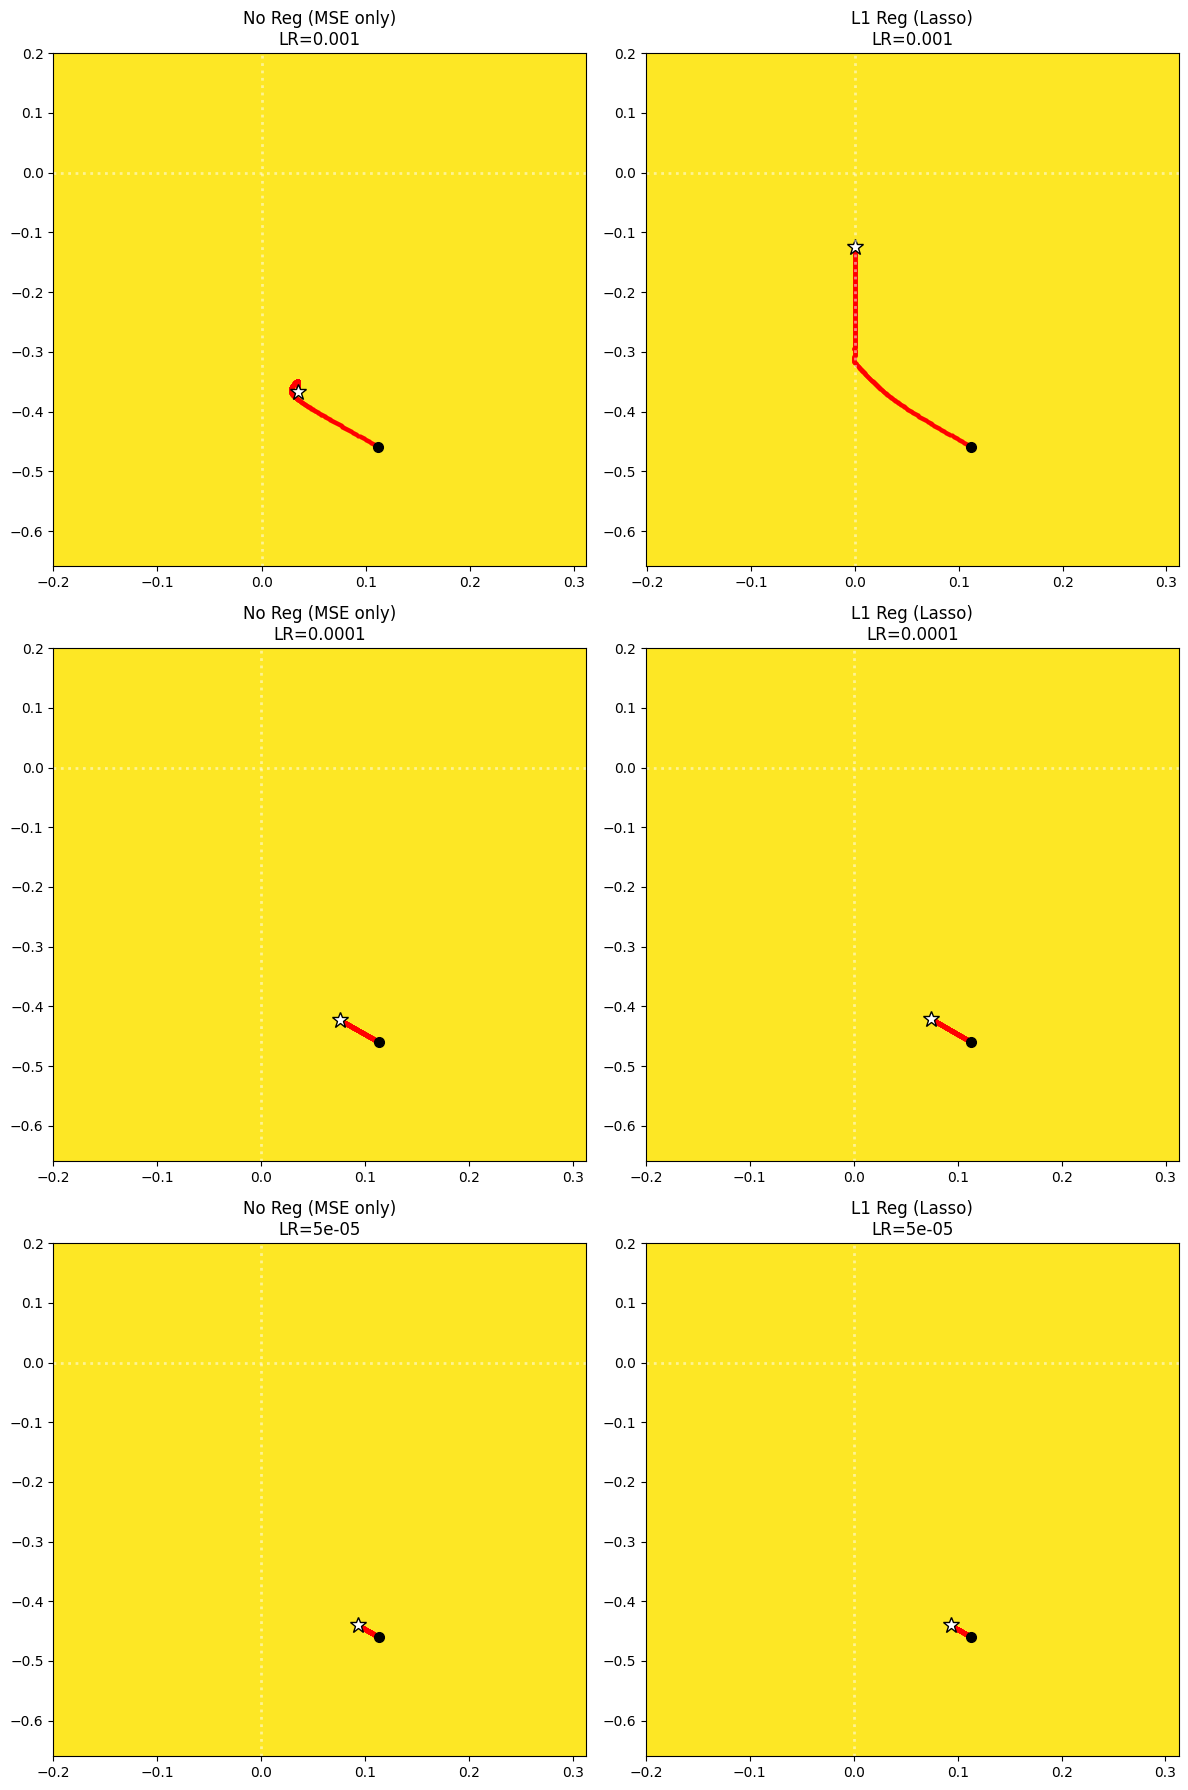

In [ ]:
import matplotlib.colors as colors
import copy

def train_and_track(lr, l1_lambda, num_epochs=400):
    torch.manual_seed(42)
    model = VariancePredictor(dim_x, dim_theta).to(device)
    
    with torch.no_grad():
        model.shared_net[0].weight.data.uniform_(-0.5, 0.5)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    idx1 = (0, 0)
    idx2 = (1, 0)

    w1_history = []
    w2_history = []

    full_x = x_train.to(device)
    full_theta = theta_train.to(device)
    cond_mean = analytical_theta_given_x(full_x).detach()

    model.train()

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        pred_var = model(full_x)

        loss = L_var_loss(pred_var, full_theta, cond_mean)
        l1_reg = l1_penalty(model, l1_lambda)
        total_loss = loss + l1_reg

        total_loss.backward()
        optimizer.step()

        w = model.shared_net[0].weight.detach().cpu().numpy()
        w1_history.append(w[idx1])
        w2_history.append(w[idx2])

    return np.array(w1_history), np.array(w2_history), model

def plot_landscape_trajectory(ax, model, w1_hist, w2_hist, l1_lambda, title):
    all_w1 = np.concatenate([w1_hist, [0]])
    all_w2 = np.concatenate([w2_hist, [0]])

    margin = 0.2
    w1_min, w1_max = all_w1.min() - margin, all_w1.max() + margin
    w2_min, w2_max = all_w2.min() - margin, all_w2.max() + margin

    grid_res = 60
    w1_range = np.linspace(w1_min, w1_max, grid_res)
    w2_range = np.linspace(w2_min, w2_max, grid_res)
    W1, W2 = np.meshgrid(w1_range, w2_range)
    Z = np.zeros_like(W1)

    batch_x = x_test[:500].to(device)
    batch_theta = theta_test[:500].to(device)
    cond_mean = analytical_theta_given_x(batch_x).detach()

    original_weights = model.shared_net[0].weight.detach().clone()
    idx1, idx2 = (0, 0), (1, 0)

    with torch.no_grad():
        for i in range(grid_res):
            for j in range(grid_res):
                temp_w = original_weights.clone()
                temp_w[idx1] = float(W1[i, j])
                temp_w[idx2] = float(W2[i, j])
                model.shared_net[0].weight.copy_(temp_w)

                pred = model(batch_x)
                mse_part = L_var_loss(pred, batch_theta, cond_mean).item()
                reg_part = l1_penalty(model, l1_lambda).item()
                Z[i, j] = mse_part + reg_part

    model.shared_net[0].weight.data = original_weights

    pcm = ax.contourf(W1, W2, Z, levels=25, cmap='viridis', norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()))

    ax.plot(w1_hist, w2_hist, 'r.-', linewidth=1.5, markersize=4, label='Путь')
    ax.plot(w1_hist[0], w2_hist[0], 'ko', markersize=7, label='Старт')

    ax.plot(w1_hist[-1], w2_hist[-1], 'w*', markersize=12, markeredgecolor='k', label='Конец')

    ax.axhline(0, color='white', alpha=0.5, linestyle=':', linewidth=2)
    ax.axvline(0, color='white', alpha=0.5, linestyle=':', linewidth=2)

    ax.set_title(title)

reg_strength = 0.01
lrs = [1e-3, 1e-4, 5e-5]

fig, axes = plt.subplots(len(lrs), 2, figsize=(12, 18))

print("Генерация ландшафтов... (ожидайте)")

for i, lr in enumerate(lrs):
    print(f"Обработка LR={lr}...")
    w1, w2, model_no_reg = train_and_track(lr=lr, l1_lambda=0.0, num_epochs=400)
    plot_landscape_trajectory(axes[i, 0], model_no_reg, w1, w2, 0.0, f"No Reg (MSE only)\nLR={lr}")

    w1_reg, w2_reg, model_reg = train_and_track(lr=lr, l1_lambda=reg_strength, num_epochs=400)
    plot_landscape_trajectory(axes[i, 1], model_reg, w1_reg, w2_reg, reg_strength, f"L1 Reg (Lasso)\nLR={lr}")

plt.tight_layout()
plt.show()